#Libary

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve, confusion_matrix)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Load Data

In [ ]:
CSV = "Churn_Modelling.csv"
df = pd.read_csv(CSV)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#Data Understanding

In [ ]:
print("shape:", df.shape,
      "| missing cells:", int(df.isna().sum().sum()),
      "| duplicate rows:", int(df.duplicated().sum()))

shape: (10000, 14) | missing cells: 0 | duplicate rows: 0


#Rename kolom snake

In [ ]:
df = df.rename(columns={
    'RowNumber':'row_number','CustomerId':'customer_id','Surname':'surname',
    'CreditScore':'credit_score','Geography':'geography','Gender':'gender',
    'Age':'age','Tenure':'tenure','Balance':'balance','NumOfProducts':'num_of_products',
    'HasCrCard':'has_credit_card','IsActiveMember':'is_active_member',
    'EstimatedSalary':'estimated_salary','Exited':'exited'
})

#Buang Kolom tidak relevan

In [ ]:
id_cols = [c for c in ['row_number','customer_id','surname'] if c in df.columns]
cust_id = df['customer_id'] if 'customer_id' in df.columns else None

# target
t = 'exited'
assert t in df.columns, "Kolom target 'exited/Exited' ga ketemu."

#Split data

In [ ]:
# drop kolom ID dari fitur
id_cols = [c for c in ['row_number','customer_id','surname'] if c in df.columns]
t = 'exited'

X = df.drop(columns=id_cols+[t])
y = df[t].astype(int)

# train/test (80/20)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# dari train bikin train_in/val (80/20) buat pilih model & threshold
X_tr_in, X_val, y_tr_in, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=42
)

print("train_in:", X_tr_in.shape, "| val:", X_val.shape, "| test:", X_te.shape)
print("churn rate train_in/val/test:",
      y_tr_in.mean().round(4), y_val.mean().round(4), y_te.mean().round(4))


train_in: (6400, 10) | val: (1600, 10) | test: (2000, 10)
churn rate train_in/val/test: 0.2037 0.2037 0.2035


#EDA

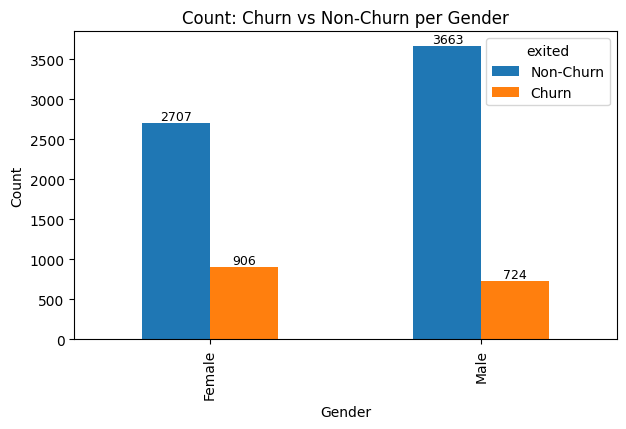

In [ ]:
tab_cnt = pd.crosstab(train['gender'], train['exited']).rename(columns={0:'Non-Churn', 1:'Churn'})
ax = tab_cnt.plot(kind='bar', figsize=(7,4))
ax.set_title('Count: Churn vs Non-Churn per Gender'); ax.set_xlabel('Gender'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()

In [ ]:
# hitung angka & rate (train set)
cnt = train.groupby('gender')['exited'].value_counts().unstack(fill_value=0)
cnt.columns = ['Non-Churn','Churn']
rate = (train.groupby('gender')['exited'].mean()*100).round(2)

print("Count per gender:\n", cnt, "\n")
print("Churn rate per gender (%):\n", rate)

# kalau butuh dua angka untuk insight
g_hi = rate.idxmax()
g_lo = rate.idxmin()
rate_hi = float(rate.max())
rate_lo = float(rate.min())
print(f"Highest rate: {g_hi} {rate_hi}%, Lowest: {g_lo} {rate_lo}%")

Count per gender:
         Non-Churn  Churn
gender                  
Female       2707    906
Male         3663    724 

Churn rate per gender (%):
 gender
Female    25.08
Male      16.50
Name: exited, dtype: float64
Highest rate: Female 25.08%, Lowest: Male 16.5%


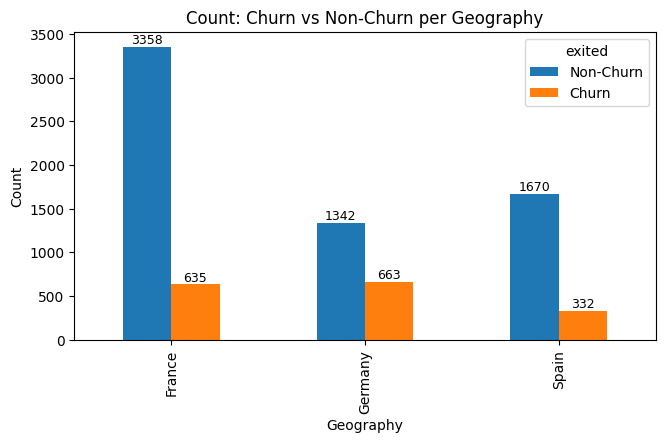

In [ ]:
tab_cnt = pd.crosstab(train['geography'], train['exited']).rename(columns={0:'Non-Churn', 1:'Churn'})
ax = tab_cnt.plot(kind='bar', figsize=(7.5,4))
ax.set_title('Count: Churn vs Non-Churn per Geography'); ax.set_xlabel('Geography'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()

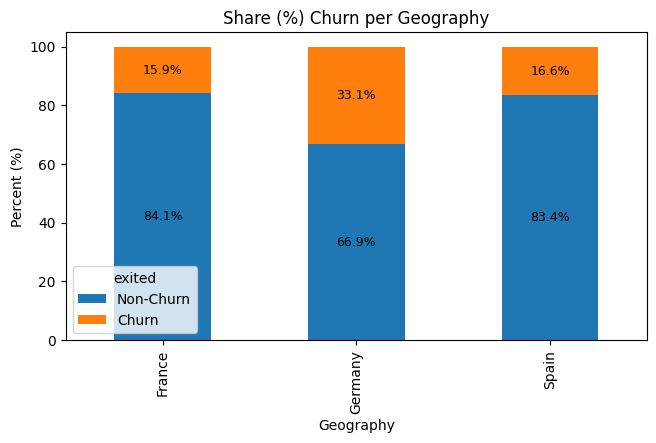

In [ ]:
tab_pct = (pd.crosstab(train['geography'], train['exited'], normalize='index')*100)\
            .rename(columns={0:'Non-Churn', 1:'Churn'})
ax = tab_pct[['Non-Churn','Churn']].plot(kind='bar', stacked=True, figsize=(7.5,4))
ax.set_title('Share (%) Churn per Geography'); ax.set_xlabel('Geography'); ax.set_ylabel('Percent (%)')
for i,(nc,ch) in enumerate(tab_pct[['Non-Churn','Churn']].values):
    ax.text(i, nc/2,    f'{nc:.1f}%', ha='center', va='center', fontsize=9)
    ax.text(i, nc+ch/2, f'{ch:.1f}%', ha='center', va='center', fontsize=9)
plt.show()

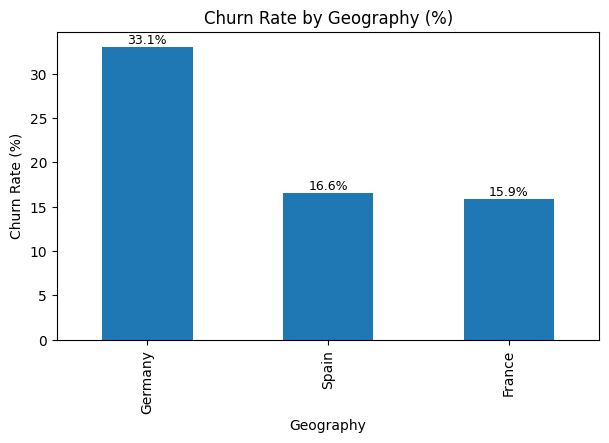

In [ ]:
rate = (train.groupby('geography')['exited'].mean()*100).round(2).sort_values(ascending=False)
ax = rate.plot(kind='bar', figsize=(7,4))
ax.set_title('Churn Rate by Geography (%)'); ax.set_xlabel('Geography'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

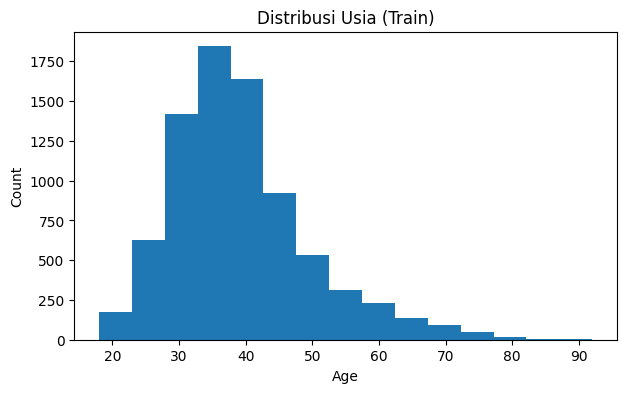

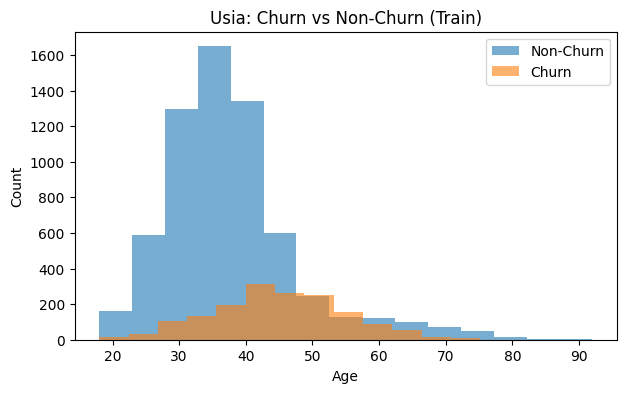

/tmp/ipython-input-3157745520.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_dec = (train.groupby(age_dec)['exited'].mean()*100).round(2)


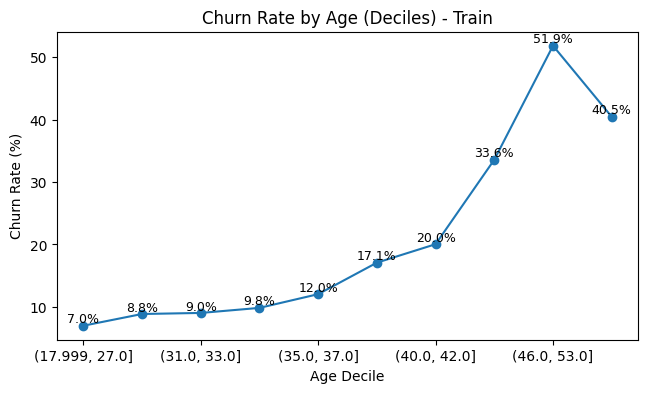

/tmp/ipython-input-3157745520.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_bucket = (train.groupby(age_bucket)['exited'].mean()*100).round(2)


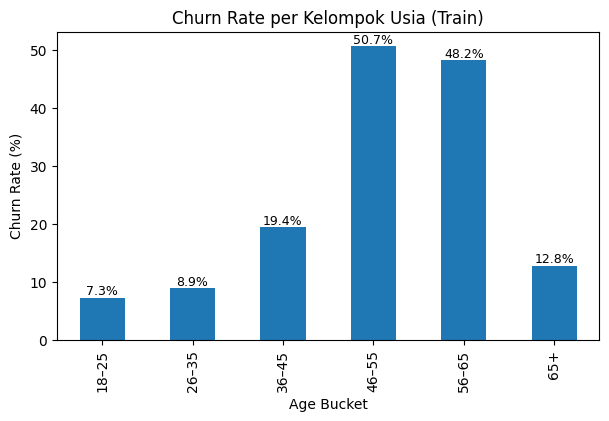

In [ ]:
# 1) Histogram usia (overall)
ax = train['age'].plot(kind='hist', bins=15, figsize=(7,4))
ax.set_title('Distribusi Usia (Train)')
ax.set_xlabel('Age'); ax.set_ylabel('Count')
plt.show()

# 2) Histogram overlay: Non-Churn vs Churn
plt.figure(figsize=(7,4))
plt.hist(train.loc[train['exited']==0, 'age'], bins=15, alpha=0.6, label='Non-Churn')
plt.hist(train.loc[train['exited']==1, 'age'], bins=15, alpha=0.6, label='Churn')
plt.title('Usia: Churn vs Non-Churn (Train)')
plt.xlabel('Age'); plt.ylabel('Count'); plt.legend()
plt.show()

# 3) Churn rate by age deciles (risiko per rentang)
age_dec = pd.qcut(train['age'], q=10, duplicates='drop')
rate_dec = (train.groupby(age_dec)['exited'].mean()*100).round(2)
ax = rate_dec.plot(marker='o', figsize=(7.5,4))
ax.set_title('Churn Rate by Age (Deciles) - Train')
ax.set_xlabel('Age Decile'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate_dec.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

# 4) (opsional) Bucket umur rapi + churn rate per bucket
bins   = [18,25,35,45,55,65,100]
labels = ['18–25','26–35','36–45','46–55','56–65','65+']
age_bucket = pd.cut(train['age'], bins=bins, labels=labels, include_lowest=True, right=True)

rate_bucket = (train.groupby(age_bucket)['exited'].mean()*100).round(2)
ax = rate_bucket.plot(kind='bar', figsize=(7,4))
ax.set_title('Churn Rate per Kelompok Usia (Train)')
ax.set_xlabel('Age Bucket'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate_bucket.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

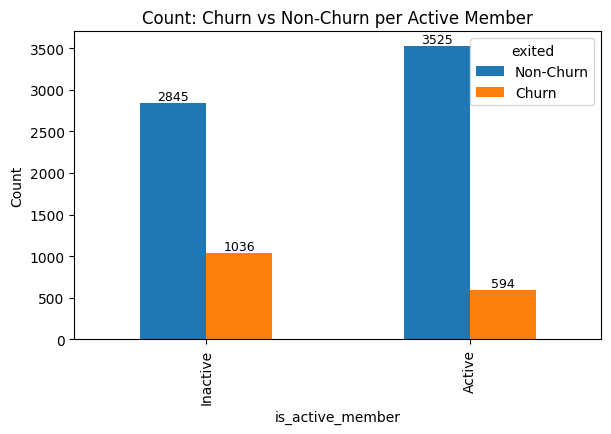

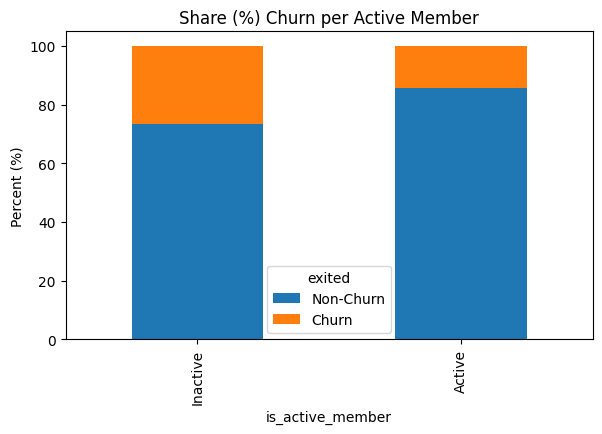

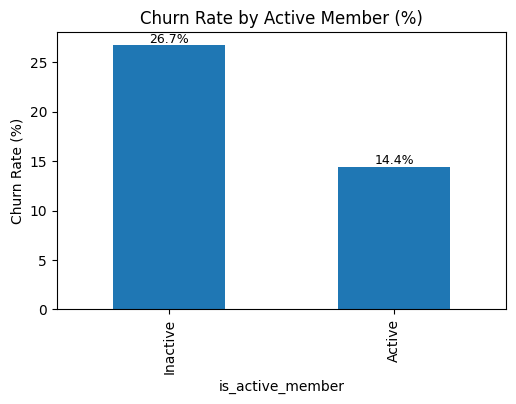

In [ ]:
# =============== 1) is_active_member ===============
# Count: churn vs non-churn
tab_cnt = pd.crosstab(train['is_active_member'], train['exited']).rename(columns={0:'Non-Churn',1:'Churn'})
tab_cnt.index = tab_cnt.index.map({0:'Inactive',1:'Active'})
ax = tab_cnt.plot(kind='bar', figsize=(6.8,4))
ax.set_title('Count: Churn vs Non-Churn per Active Member'); ax.set_xlabel('is_active_member'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=9)
plt.show()

# 100% stacked (proporsi di tiap kategori)
tab_pct = (pd.crosstab(train['is_active_member'], train['exited'], normalize='index')*100)\
            .rename(columns={0:'Non-Churn',1:'Churn'})
tab_pct.index = tab_pct.index.map({0:'Inactive',1:'Active'})
ax = tab_pct[['Non-Churn','Churn']].plot(kind='bar', stacked=True, figsize=(6.8,4))
ax.set_title('Share (%) Churn per Active Member'); ax.set_xlabel('is_active_member'); ax.set_ylabel('Percent (%)')
plt.show()

# Churn rate (%)
rate_act = (train.groupby('is_active_member')['exited'].mean()*100).rename({0:'Inactive',1:'Active'})
ax = rate_act.rename(index={0:'Inactive',1:'Active'}).plot(kind='bar', figsize=(5.8,3.6))
ax.set_title('Churn Rate by Active Member (%)'); ax.set_xlabel('is_active_member'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate_act.rename(index={0:'Inactive',1:'Active'}).values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

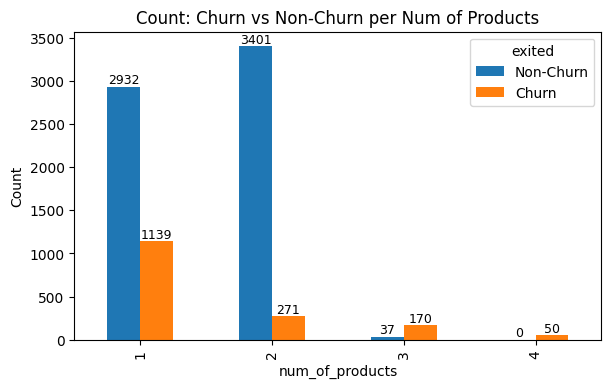

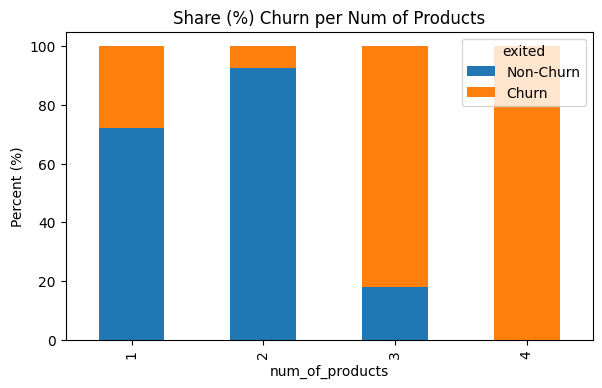

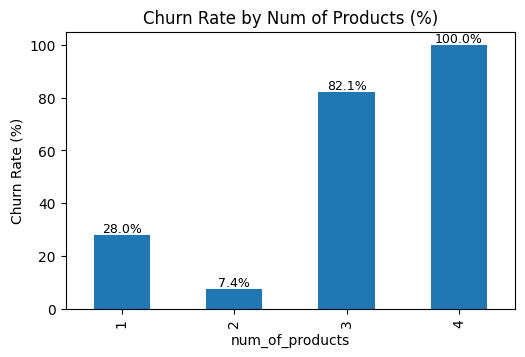

In [ ]:
# =============== 2) num_of_products ===============
# Count: churn vs non-churn
order = sorted(train['num_of_products'].unique())
tab_cnt_np = pd.crosstab(train['num_of_products'], train['exited']).loc[order].rename(columns={0:'Non-Churn',1:'Churn'})
ax = tab_cnt_np.plot(kind='bar', figsize=(6.8,4))
ax.set_title('Count: Churn vs Non-Churn per Num of Products'); ax.set_xlabel('num_of_products'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=9)
plt.show()

# 100% stacked (proporsi di tiap jumlah produk)
tab_pct_np = (pd.crosstab(train['num_of_products'], train['exited'], normalize='index')*100)\
               .rename(columns={0:'Non-Churn',1:'Churn'}).loc[order]
ax = tab_pct_np[['Non-Churn','Churn']].plot(kind='bar', stacked=True, figsize=(6.8,4))
ax.set_title('Share (%) Churn per Num of Products'); ax.set_xlabel('num_of_products'); ax.set_ylabel('Percent (%)')
plt.show()

# Churn rate (%)
rate_np = (train.groupby('num_of_products')['exited'].mean()*100).loc[order]
ax = rate_np.plot(kind='bar', figsize=(5.8,3.6))
ax.set_title('Churn Rate by Num of Products (%)'); ax.set_xlabel('num_of_products'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate_np.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

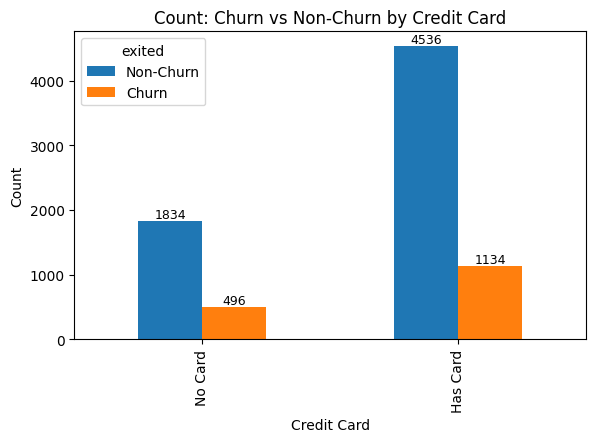

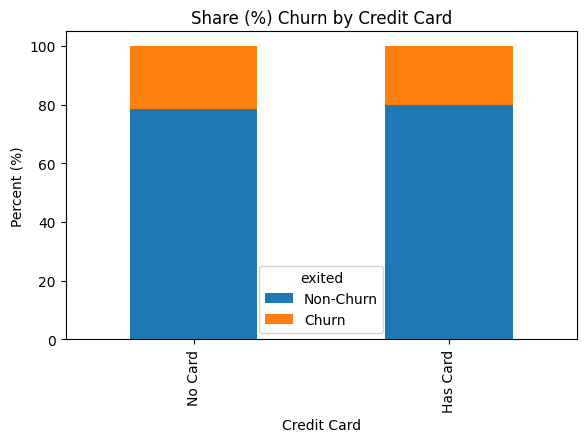

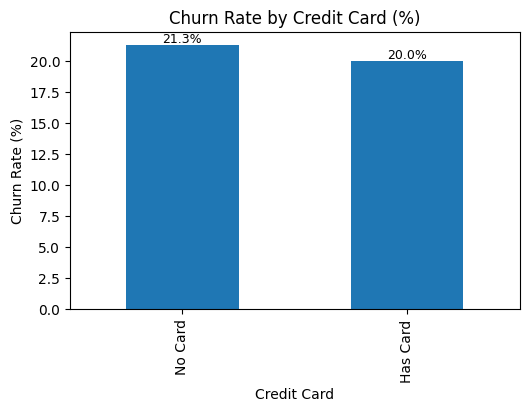

,Total,Churn,ChurnRate_%
has_credit_card,,,
No Card,2330,496,21.29
Has Card,5670,1134,20.00


Share of total churn (%):
 has_credit_card
Has Card    69.6
No Card     30.4


In [ ]:
# auto-rename kalau masih pakai nama lama
if 'has_credit_card' not in train.columns and 'HasCrCard' in train.columns:
    train = train.rename(columns={'HasCrCard':'has_credit_card'})

# === 1) COUNT: Non-churn vs Churn per status kartu kredit ===
tab_cnt = pd.crosstab(train['has_credit_card'], train['exited'])\
           .rename(index={0:'No Card', 1:'Has Card'},
                   columns={0:'Non-Churn', 1:'Churn'})
ax = tab_cnt.plot(kind='bar', figsize=(6.6,4))
ax.set_title('Count: Churn vs Non-Churn by Credit Card'); ax.set_xlabel('Credit Card'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()

# === 2) 100% STACKED: proporsi churn di tiap status kartu ===
tab_pct = (pd.crosstab(train['has_credit_card'], train['exited'], normalize='index')*100)\
            .rename(index={0:'No Card', 1:'Has Card'},
                    columns={0:'Non-Churn', 1:'Churn'})
ax = tab_pct[['Non-Churn','Churn']].plot(kind='bar', stacked=True, figsize=(6.6,4))
ax.set_title('Share (%) Churn by Credit Card'); ax.set_xlabel('Credit Card'); ax.set_ylabel('Percent (%)')
plt.show()

# === 3) CHURN RATE: persentase churn (risiko) ===
rate = (train.groupby('has_credit_card')['exited'].mean()*100)\
         .rename(index={0:'No Card', 1:'Has Card'}).round(2)
ax = rate.plot(kind='bar', figsize=(5.8,3.6))
ax.set_title('Churn Rate by Credit Card (%)'); ax.set_xlabel('Credit Card'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

# === 4) Ringkasan angka (buat isi teks slide cepat) ===
summary = (train.groupby('has_credit_card')['exited']
           .agg(Total='count', Churn='sum'))
summary['ChurnRate_%'] = (summary['Churn']/summary['Total']*100).round(2)
summary = summary.rename(index={0:'No Card', 1:'Has Card'})
display(summary)

share_of_churn = (train.loc[train['exited']==1, 'has_credit_card']
                  .value_counts(normalize=True).rename(index={0:'No Card',1:'Has Card'})*100).round(1)
print('Share of total churn (%):\n', share_of_churn.to_string())


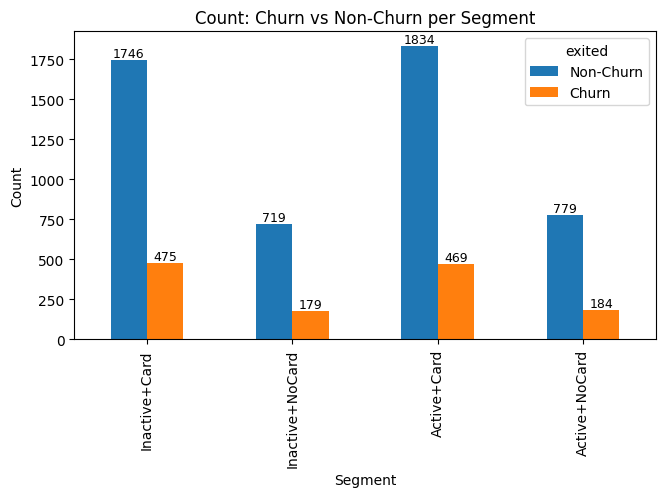

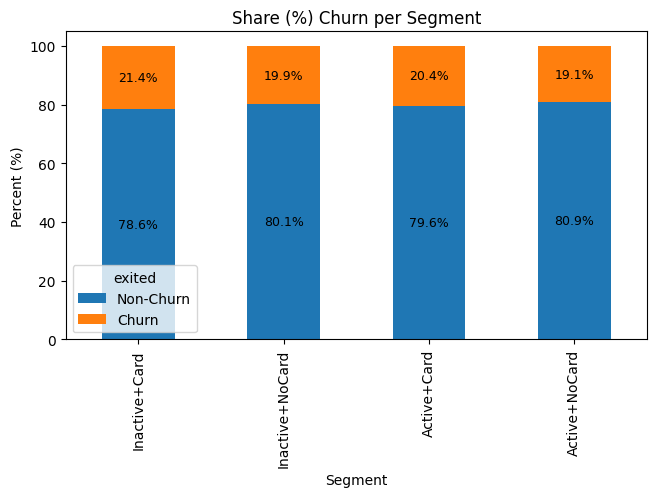

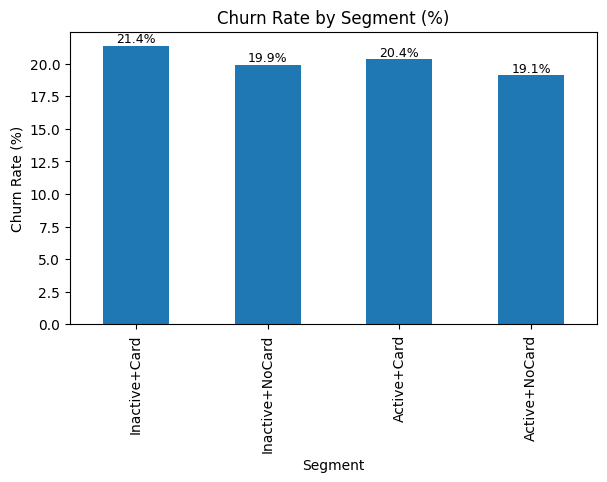

exited,Non-Churn,Churn,Total,ChurnRate_pct
segment,,,,
Inactive+Card,1746,475,2221,21.39
Inactive+NoCard,719,179,898,19.93
Active+Card,1834,469,2303,20.36
Active+NoCard,779,184,963,19.11


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
colmap = {'HasCrCard':'has_credit_card', 'IsActiveMember':'is_active_member', 'Exited':'exited'}
train = train.rename(columns={k:v for k,v in colmap.items() if k in train.columns})

# --- bikin SERI segmen (tanpa nambah kolom permanen) ---
segment = pd.Series(np.select(
    [
        (train['has_credit_card']==1) & (train['is_active_member']==0),  # punya kartu, tidak aktif
        (train['has_credit_card']==0) & (train['is_active_member']==0),  # tidak punya kartu, tidak aktif
        (train['has_credit_card']==1) & (train['is_active_member']==1),  # punya kartu, aktif
        (train['has_credit_card']==0) & (train['is_active_member']==1),  # tidak punya kartu, aktif
    ],
    ['Inactive+Card','Inactive+NoCard','Active+Card','Active+NoCard'],
    default='Other'
), name='segment')

order = ['Inactive+Card','Inactive+NoCard','Active+Card','Active+NoCard']

# ===== 1) COUNT: churn vs non-churn per segmen =====
tab_cnt = pd.crosstab(segment, train['exited']).rename(columns={0:'Non-Churn',1:'Churn'}).reindex(order)
ax = tab_cnt.plot(kind='bar', figsize=(7.5,4))
ax.set_title('Count: Churn vs Non-Churn per Segment'); ax.set_xlabel('Segment'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()

# ===== 2) 100% STACKED: proporsi churn per segmen =====
tab_pct = (pd.crosstab(segment, train['exited'], normalize='index')*100)\
            .rename(columns={0:'Non-Churn',1:'Churn'}).reindex(order)
ax = tab_pct[['Non-Churn','Churn']].plot(kind='bar', stacked=True, figsize=(7.5,4))
ax.set_title('Share (%) Churn per Segment'); ax.set_xlabel('Segment'); ax.set_ylabel('Percent (%)')
for i,(nc,ch) in enumerate(tab_pct[['Non-Churn','Churn']].values):
    ax.text(i, nc/2, f'{nc:.1f}%', ha='center', va='center', fontsize=9)
    ax.text(i, nc+ch/2, f'{ch:.1f}%', ha='center', va='center', fontsize=9)
plt.show()

# ===== 3) CHURN RATE: risiko per segmen =====
rate = (pd.crosstab(segment, train['exited'], normalize='index')[1]*100).reindex(order).round(2)
ax = rate.plot(kind='bar', figsize=(6.8,3.8))
ax.set_title('Churn Rate by Segment (%)'); ax.set_xlabel('Segment'); ax.set_ylabel('Churn Rate (%)')
for i,v in enumerate(rate.values):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
plt.show()

# ===== 4) Ringkasan buat isi slide =====
summary = (pd.crosstab(segment, train['exited'])
           .rename(columns={0:'Non-Churn',1:'Churn'})
           .assign(Total=lambda x: x.sum(1),
                   ChurnRate_pct=lambda x: (x['Churn']/x['Total']*100).round(2))
           .reindex(order))
display(summary)

share_of_churn = (segment[train['exited']==1].value_counts(normalize=True).reindex(order)*100).round(1)
print('Share of total churn (%):\n', share_of_churn.to_string())

In [ ]:
# gabung train utk EDA
train = X_tr.copy(); train[t] = y_tr

# helper save/show
def _save(path=None):
    if path:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.close()
    else:
        plt.tight_layout(); plt.show()

# 3.1 distribusi target (count & %)
plt.figure(figsize=(5.5,3.5))
train[t].value_counts().sort_index().plot(kind='bar')
plt.title('Train: Non-Churn (0) vs Churn (1)'), plt.xlabel('Label'), plt.ylabel('Count')
for i,v in enumerate(train[t].value_counts().sort_index().values):
    plt.text(i, v, f'{int(v)}', ha='center', va='bottom')
_save('figs/eda_target_count.png')

# 3.2 churn rate per kategori
def plot_rate_cat(col, save=None):
    rate = (train.groupby(col)[t].mean()*100).round(2).sort_values(ascending=False)
    plt.figure(figsize=(6.5,3.6))
    rate.plot(kind='bar'); plt.title(f'Churn Rate by {col.title()} (%)')
    plt.xlabel(col.title()); plt.ylabel('Churn Rate (%)')
    for i,v in enumerate(rate.values): plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    _save(save)

for c in ['geography','gender','is_active_member','num_of_products','has_credit_card']:
    plot_rate_cat(c, save=f'figs/eda_rate_{c}.png')

# 3.3 decile churn untuk numerik
def plot_decile(num_col, save=None):
    bins = pd.qcut(train[num_col], q=10, duplicates='drop')
    rate = (train.groupby(bins)[t].mean()*100).round(2)
    plt.figure(figsize=(6.5,3.6))
    rate.plot(marker='o'); plt.title(f'Churn Rate by {num_col} (Deciles)')
    plt.xlabel('Decile'); plt.ylabel('Churn Rate (%)')
    for i,v in enumerate(rate.values): plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    _save(save)

for c in ['credit_score','age','tenure','balance','estimated_salary']:
    plot_decile(c, save=f'figs/eda_decile_{c}.png')


/tmp/ipython-input-431107237.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = (train.groupby(bins)[t].mean()*100).round(2)
/tmp/ipython-input-431107237.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = (train.groupby(bins)[t].mean()*100).round(2)
/tmp/ipython-input-431107237.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = (train.groupby(bins)[t].mean()*100).round(2)
/tmp/ipython-input-431

In [ ]:
def add_features(df_):
    df2 = df_.copy()
    df2['balance_to_salary'] = df2['balance'] / (df2['estimated_salary'] + 1)
    df2['products_ge_2']     = (df2['num_of_products'] >= 2).astype(int)
    df2['age_tenure_ratio']  = df2['age'] / (df2['tenure'] + 1)
    df2['inactive_card']     = ((df2['has_credit_card']==1) & (df2['is_active_member']==0)).astype(int)

    # fixed bands (no fit → aman)
    bins = [0,580,670,740,800,900]
    labs = ['poor','fair','good','very_good','excellent']
    df2['credit_score_bucket'] = pd.cut(df2['credit_score'], bins=bins, labels=labs, include_lowest=True)

    # log transform
    df2['log_balance']          = np.log1p(df2['balance'].clip(lower=0))
    df2['log_estimated_salary'] = np.log1p(df2['estimated_salary'].clip(lower=0))

    # opsional indikator
    df2['zero_balance'] = (df2['balance']==0).astype(int)
    return df2

# apply ke semua split
X_tr_in_fe = add_features(X_tr_in)
X_val_fe   = add_features(X_val)
X_tr_fe    = add_features(X_tr)
X_te_fe    = add_features(X_te)


In [ ]:
# kategori & numerik utk +FE
cat_fe = [c for c in ['geography','gender','credit_score_bucket'] if c in X_tr_in_fe.columns]
num_fe = [c for c in X_tr_in_fe.columns if c not in cat_fe]

# LogReg perlu scaler; tree cukup OHE
pre_fe_logreg = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_fe),
    ('num', StandardScaler(), num_fe)
])
pre_fe_tree = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_fe)
], remainder='passthrough')

# imbalance ratio buat boosting
w_pos = (len(y_tr_in) - y_tr_in.sum()) / y_tr_in.sum()

models = {
    'LOGREG (+FE)': Pipeline([
        ('pp', pre_fe_logreg),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'HGB (+FE)': Pipeline([
        ('pp', pre_fe_tree),
        ('clf', HistGradientBoostingClassifier(random_state=42))
    ]),
    'RF (+FE)': Pipeline([
        ('pp', pre_fe_tree),
        ('clf', RandomForestClassifier(
            n_estimators=500, class_weight='balanced_subsample',
            n_jobs=-1, random_state=42
        ))
    ]),
    'XGB (+FE)': Pipeline([
        ('pp', pre_fe_tree),
        ('clf', XGBClassifier(
            n_estimators=600, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, n_jobs=-1,
            random_state=42, eval_metric='logloss', tree_method='hist',
            scale_pos_weight=w_pos
        ))
    ]),
    'LGBM (+FE)': Pipeline([
        ('pp', pre_fe_tree),
        ('clf', LGBMClassifier(
            n_estimators=800, learning_rate=0.05, num_leaves=31,
            subsample=0.8, colsample_bytree=0.8, n_jobs=-1,
            random_state=42, scale_pos_weight=w_pos
        ))
    ]),
}


In [ ]:
def recall_at_k(y_true, scores, k=0.10):
    n = max(1, int(len(scores)*k))
    idx = np.argsort(-scores)[:n]
    return float(pd.Series(y_true).iloc[idx].mean())

def eval_val(name, pipe):
    if 'HGB' in name:
        pipe.fit(X_tr_in_fe, y_tr_in, clf__sample_weight=np.where(y_tr_in==1, w_pos, 1.0))
    else:
        pipe.fit(X_tr_in_fe, y_tr_in)
    p = pipe.predict_proba(X_val_fe)[:,1]
    return {
        'model': name,
        'roc_auc': roc_auc_score(y_val, p),
        'pr_auc':  average_precision_score(y_val, p),
        'recall@10': recall_at_k(y_val, p, 0.10),
        'pipe': pipe, 'proba_val': p
    }

res_val = [eval_val(n, m) for n,m in models.items()]
tbl_val = pd.DataFrame([{k:(round(v,4) if isinstance(v,float) else v)
                         for k,v in r.items() if k not in ['pipe','proba_val']} for r in res_val])
print("\n=== VALIDATION ABLATION (rank by PR-AUC) ===")
display(tbl_val.sort_values('pr_auc', ascending=False))


[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1888
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019

=== VALIDATION ABLATION (rank by PR-AUC) ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,roc_auc,pr_auc,recall@10
1,HGB (+FE),0.8639,0.6911,0.8187
2,RF (+FE),0.8612,0.6777,0.8125
4,LGBM (+FE),0.8480,0.6684,0.8063
3,XGB (+FE),0.8385,0.6545,0.7875
0,LOGREG (+FE),0.8312,0.6120,0.7250


In [ ]:
from copy import deepcopy

# helper: recall@Top-K (K=10% default)
def recall_at_k(y_true, y_score, k=0.10):
    y_true = np.asarray(y_true)
    k = max(1, int(np.ceil(k * len(y_score))))
    idx = np.argsort(y_score)[::-1][:k]
    return y_true[idx].mean()

# evaluasi 1 model sekaligus untuk Train & Test
def eval_train_test(pipe, X_tr, y_tr, X_te, y_te, k=0.10):
    p_tr = pipe.predict_proba(X_tr)[:, 1]
    p_te = pipe.predict_proba(X_te)[:, 1]
    return {
        ('pr_auc', 'Train'):  average_precision_score(y_tr, p_tr),
        ('pr_auc', 'Test'):   average_precision_score(y_te, p_te),
        ('roc_auc','Train'):  roc_auc_score(y_tr, p_tr),
        ('roc_auc','Test'):   roc_auc_score(y_te, p_te),
        ('recall@10%','Train'): recall_at_k(y_tr, p_tr, k),
        ('recall@10%','Test'):  recall_at_k(y_te, p_te, k),
    }

# loop semua model -> fit di TRAIN -> hitung metric Train & Test
rows = []
for name, pipe in models.items():
    m = deepcopy(pipe).fit(X_tr_fe, y_tr)       # fit di train
    met = eval_train_test(m, X_tr_fe, y_tr, X_te_fe, y_te, k=0.10)
    rows.append({'classifier': name, **met})

# DataFrame dengan kolom multiindex (metric × dataset)
tbl_tt = pd.DataFrame(rows).set_index('classifier')
display(tbl_tt.round(3))

# Versi ringkas: hanya kolom Test, diurut PR-AUC (Test)
cols_test = [('pr_auc','Test'), ('roc_auc','Test'), ('recall@10%','Test')]
tbl_test = tbl_tt[cols_test].sort_values(('pr_auc','Test'), ascending=False)
print("\n=== RANK by PR-AUC (TEST) ===")
display(tbl_test.round(3))

[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,"(pr_auc, Train)","(pr_auc, Test)","(roc_auc, Train)","(roc_auc, Test)","(recall@10%, Train)","(recall@10%, Test)"
classifier,,,,,,
LOGREG (+FE),0.617,0.628,0.835,0.837,0.709,0.725
HGB (+FE),0.911,0.708,0.972,0.861,0.978,0.825
RF (+FE),1.000,0.687,1.000,0.855,1.000,0.805
XGB (+FE),0.996,0.676,0.999,0.843,1.000,0.805
LGBM (+FE),0.999,0.677,1.000,0.841,1.000,0.785



=== RANK by PR-AUC (TEST) ===


,"(pr_auc, Test)","(roc_auc, Test)","(recall@10%, Test)"
classifier,,,
HGB (+FE),0.708,0.861,0.825
RF (+FE),0.687,0.855,0.805
LGBM (+FE),0.677,0.841,0.785
XGB (+FE),0.676,0.843,0.805
LOGREG (+FE),0.628,0.837,0.725


In [ ]:
# ambil yang terbaik
best_idx = int(np.argmax([r['pr_auc'] for r in res_val]))
best_name = res_val[best_idx]['model']
best_pipe = res_val[best_idx]['pipe']
p_val = res_val[best_idx]['proba_val']

# fungsi pilih threshold by profit
BENEFIT_TP, COST_FP, LOSS_FN = 50_000, 5_000, 30_000  # GANTI ke asumsi kamu
def best_threshold(y_true, scores):
    best = (-1, 0.5, (0,0,0))
    y = np.asarray(y_true); s = np.asarray(scores)
    for thr in np.linspace(0.05,0.95,19):
        pred = (s >= thr).astype(int)
        tp = int(((pred==1)&(y==1)).sum())
        fp = int(((pred==1)&(y==0)).sum())
        fn = int(((pred==0)&(y==1)).sum())
        profit = tp*BENEFIT_TP - fp*COST_FP - fn*LOSS_FN
        if profit > best[0]: best = (int(profit), float(thr), (tp,fp,fn))
    return best

prof_val, thr_best, (tp_v, fp_v, fn_v) = best_threshold(y_val, p_val)
print(f"Best on VAL: {best_name} | thr={thr_best:.2f} | Profit={prof_val} | TP={tp_v} FP={fp_v} FN={fn_v}")


Best on VAL: HGB (+FE) | thr=0.20 | Profit=11335000 | TP=296 FP=513 FN=30



=== FINAL TEST ===
{'model': 'HGB (+FE)', 'ROC-AUC': np.float64(0.8612), 'PR-AUC': np.float64(0.7039), 'Recall@10%': 0.825, 'TP': np.int64(366), 'FP': np.int64(685), 'FN': np.int64(41), 'TN': np.int64(908), 'Profit@thr': np.int64(13645000), 'thr': 0.2}


NameError: name '_save' is not defined

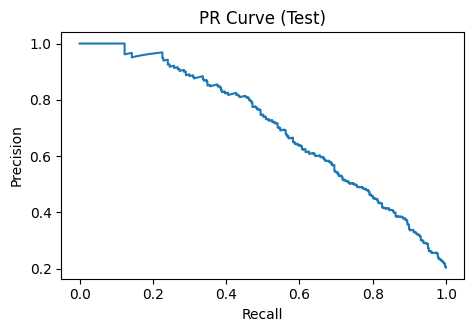

In [ ]:
# fit ulang best model ke FULL TRAIN (X_tr_fe,y_tr)
if 'HGB' in best_name:
    best_pipe.fit(X_tr_fe, y_tr, clf__sample_weight=np.where(y_tr==1, (len(y_tr)-y_tr.sum())/y_tr.sum(), 1.0))
else:
    best_pipe.fit(X_tr_fe, y_tr)

# proba & metrik test
p_test = best_pipe.predict_proba(X_te_fe)[:,1]
roc  = roc_auc_score(y_te, p_test)
pr   = average_precision_score(y_te, p_test)

# Recall@Top10%
def recall_at_k(y_true, scores, k=0.10):
    n = max(1, int(len(scores)*k))
    idx = np.argsort(-scores)[:n]
    return float(pd.Series(y_true).iloc[idx].mean())
r10 = recall_at_k(y_te, p_test, 0.10)

# confusion @ threshold dari validation
yhat = (p_test >= thr_best).astype(int)
tn, fp, fn, tp = confusion_matrix(y_te, yhat).ravel()
profit_test = tp*BENEFIT_TP - fp*COST_FP - fn*LOSS_FN

print("\n=== FINAL TEST ===")
print({'model': best_name, 'ROC-AUC': round(roc,4), 'PR-AUC': round(pr,4),
       'Recall@10%': round(r10,4), 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
       'Profit@thr': profit_test, 'thr': round(thr_best,2)})

# PR & ROC plots (buat PPT)
prec, rec, _ = precision_recall_curve(y_te, p_test)
fpr, tpr, _  = roc_curve(y_te, p_test)

plt.figure(figsize=(5.2,3.2)); plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve (Test)'); _save('figs/pr_curve_test.png')
plt.figure(figsize=(5.2,3.2)); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)'); _save('figs/roc_curve_test.png')


[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,auc_test,thr_opt(val),tpr@thr,fpr@thr
1,HGB (+FE),0.861,0.175,0.771,0.200
2,RF (+FE),0.855,0.350,0.580,0.083
3,XGB (+FE),0.843,0.425,0.673,0.144
4,LGBM (+FE),0.841,0.500,0.607,0.104
0,LOGREG (+FE),0.837,0.200,0.963,0.659


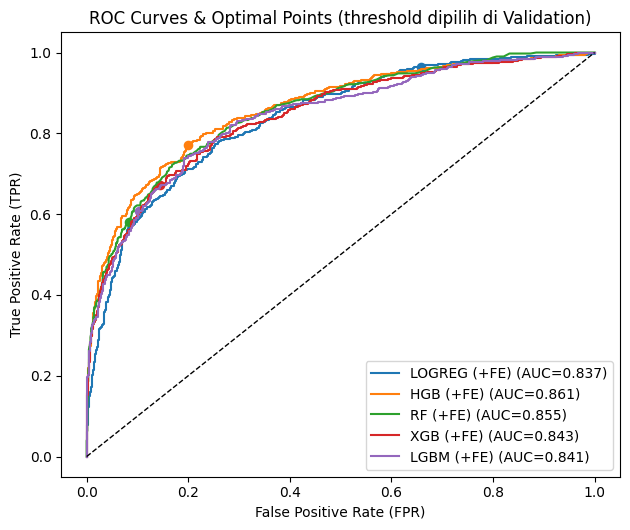

In [ ]:
from copy import deepcopy
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- 1) Helper: pilih threshold berdasarkan profit (VALIDATION) ---
def choose_thr_by_profit(y_true, p, benefit_tp=50_000, cost_fp=5_000, loss_fn=30_000):
    best = (-1, 0.0)  # (profit, thr)
    for thr in np.linspace(0.05, 0.50, 19):
        pred = (p >= thr).astype(int)
        tp = ((pred==1) & (y_true==1)).sum()
        fp = ((pred==1) & (y_true==0)).sum()
        fn = ((pred==0) & (y_true==1)).sum()
        profit = benefit_tp*tp - cost_fp*fp - loss_fn*fn
        if profit > best[0]:
            best = (profit, float(thr))
    return best[1]

# (Alternatif Youden's J di VALIDATION)
def choose_thr_by_youden(y_true, p):
    fpr, tpr, ths = roc_curve(y_true, p)
    i = np.argmax(tpr - fpr)
    return float(ths[i])

# --- 2) Gambar ROC Test semua model & tandai titik threshold optimal ---
Path('figs').mkdir(exist_ok=True)

rows = []
plt.figure(figsize=(6.4, 5.4))

for name, pipe in models.items():
    m = deepcopy(pipe).fit(X_tr_fe, y_tr)

    # pilih threshold optimal di VALIDATION (ganti fungsi jika mau Youden/F1)
    p_val = m.predict_proba(X_val_fe)[:, 1]
    thr_opt = choose_thr_by_profit(y_val, p_val)
    # thr_opt = choose_thr_by_youden(y_val, p_val)  # opsi lain

    # evaluasi di TEST (ROC + titik pada threshold tadi)
    p_test = m.predict_proba(X_te_fe)[:, 1]
    auc = roc_auc_score(y_te, p_test)
    fpr, tpr, ths = roc_curve(y_te, p_test)
    i = np.argmin(np.abs(ths - thr_opt))  # posisi threshold di kurva ROC test

    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
    plt.scatter(fpr[i], tpr[i], s=35)     # marker threshold optimal

    rows.append({
        'model': name,
        'auc_test': auc,
        'thr_opt(val)': thr_opt,
        'tpr@thr': float(tpr[i]),
        'fpr@thr': float(fpr[i]),
    })

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves & Optimal Points (threshold dipilih di Validation)')
plt.legend()
plt.tight_layout()
plt.savefig('figs/roc_optimal.png', dpi=150)

tbl = pd.DataFrame(rows).sort_values('auc_test', ascending=False)
display(tbl.round(3))

Top fitur (Permutation Importance, Test, scoring=AP):


,delta_AP
num_of_products,0.281167
age,0.224194
is_active_member,0.088745
geography,0.060413
balance,0.053024
balance_to_salary,0.014148
gender,0.008754
age_tenure_ratio,0.007529
has_credit_card,0.001383
inactive_card,0.000558


FileNotFoundError: [Errno 2] No such file or directory: 'figs/perm_importance_top10.png'

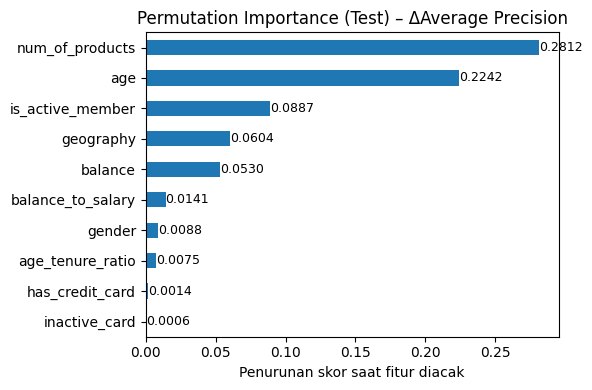

In [ ]:
# === PERMUTATION IMPORTANCE (Test) ===
from sklearn.inspection import permutation_importance

# langsung pakai pipeline + X_te_fe (fitur mentah setelah add_features, sebelum OHE)
r = permutation_importance(
    best_pipe, X_te_fe, y_te,
    scoring="average_precision",  # selaras dengan PR-AUC/recall@topK fokus churn
    n_repeats=10, random_state=42, n_jobs=-1
)

pi = pd.Series(r.importances_mean, index=X_te_fe.columns).sort_values(ascending=False)

top_k = 10
top_pi = pi.head(top_k)

print("Top fitur (Permutation Importance, Test, scoring=AP):")
display(top_pi.to_frame("delta_AP"))

# plot
ax = top_pi.iloc[::-1].plot(kind='barh', figsize=(6,4))
ax.set_title(f"Permutation Importance (Test) – ΔAverage Precision")
ax.set_xlabel("Penurunan skor saat fitur diacak")
for p in ax.patches:
    ax.text(p.get_width()+1e-6, p.get_y()+p.get_height()/2,
            f"{p.get_width():.4f}", va='center', fontsize=9)
plt.tight_layout()
plt.savefig("figs/perm_importance_top10.png", dpi=150)
plt.show()
